In [27]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import timesynth as ts # package for generating time series

import matplotlib.pyplot as plt
import sys
from qolmat.imputations.rpca.utils import drawing, utils
from qolmat.imputations.rpca.pcp_rpca import PcpRPCA
from qolmat.imputations.rpca.temporal_rpca import TemporalRPCA, OnlineTemporalRPCA

**Generate synthetic data**

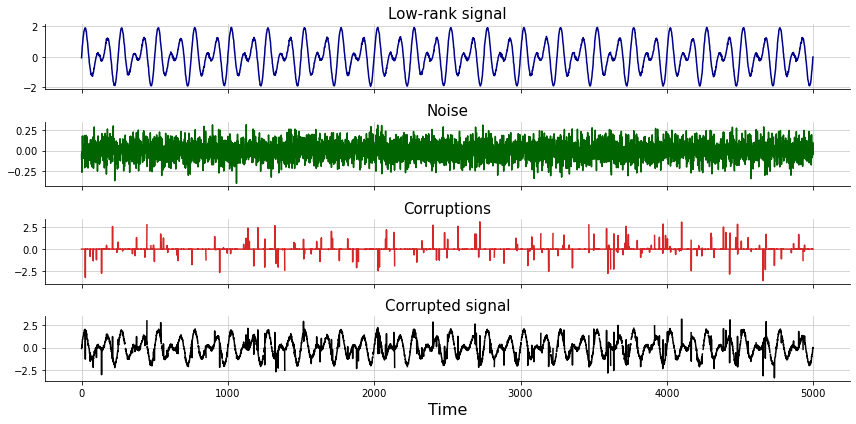

In [28]:
#np.random.seed(903)

################################################################################

time_sampler = ts.TimeSampler(stop_time=20)
irregular_time_samples = time_sampler.sample_irregular_time(num_points=5_000, keep_percentage=100)
sinusoid = ts.signals.Sinusoidal(frequency=2)
white_noise = ts.noise.GaussianNoise(std=0.1)
timeseries = ts.TimeSeries(sinusoid, noise_generator=white_noise)
samples, signals, errors = timeseries.sample(irregular_time_samples)

n = len(samples)
pc = 0.02
indices_ano1 = np.random.choice(n, int(n*pc))
samples[indices_ano1] = [np.random.uniform(low=2*np.min(samples), high=2*np.max(samples)) for i in range(int(n*pc))]
indices = np.random.choice(n, int(n*pc))
samples[indices] = np.nan


################################################################################

time_sampler = ts.TimeSampler(stop_time=20)
irregular_time_samples = time_sampler.sample_irregular_time(num_points=5_000, keep_percentage=100)
sinusoid = ts.signals.Sinusoidal(frequency=3)
white_noise = ts.noise.GaussianNoise(std=0)
timeseries = ts.TimeSeries(sinusoid, noise_generator=white_noise)
samples2, signals2, errors2 = timeseries.sample(irregular_time_samples)

n2 = len(samples2)
indices_ano2 = np.random.choice(n2, int(n*pc))
samples2[indices_ano2] = [np.random.uniform(low=2*np.min(samples2), high=2*np.max(samples2)) for i in range(int(n2*pc))]
indices = np.random.choice(n2, int(n*pc))
samples2[indices] = np.nan

samples += samples2
signals += signals2
errors += errors2

################################################################################

fig, ax = plt.subplots(4, 1, sharex=True, figsize=(12,6))
ax[0].plot(range(n), signals, c="darkblue")
ax[0].set_title("Low-rank signal", fontsize=15)
ax[1].plot(range(n), errors, c="darkgreen")
ax[1].set_title("Noise", fontsize=15)
ax[2].plot(range(n), samples-signals-errors, c="tab:red")
ax[2].set_title("Corruptions", fontsize=15)
ax[3].plot(range(n), samples, c="k")
ax[3].set_title("Corrupted signal", fontsize=15)
ax[3].set_xlabel("Time", fontsize=16)
plt.tight_layout()
plt.show()

**RPCA**

CPU times: user 2.11 s, sys: 67.8 ms, total: 2.18 s
Wall time: 704 ms


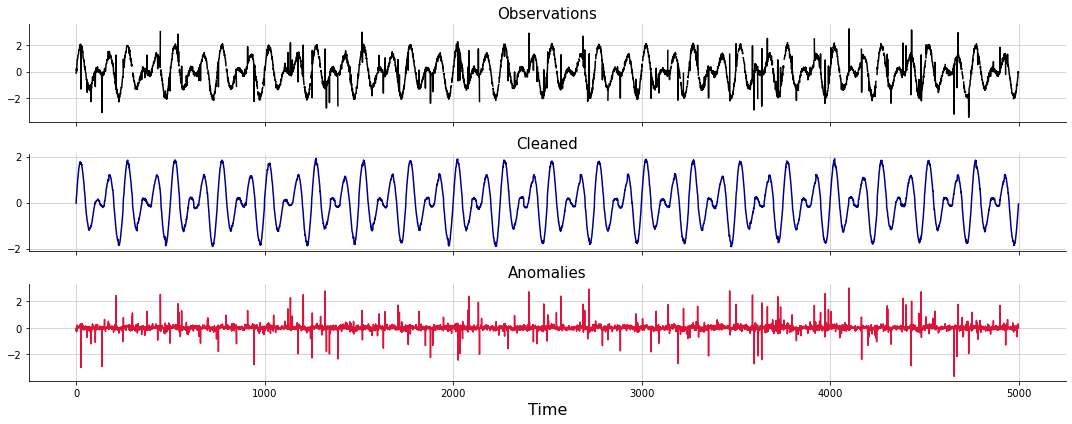

In [29]:
%%time

pcp_rpca = PcpRPCA(n_rows=25)
X, A, errors = pcp_rpca.fit_transform(signal=samples)
drawing.plot_signal([samples, X, A], style="matplotlib")

**improve PCA**

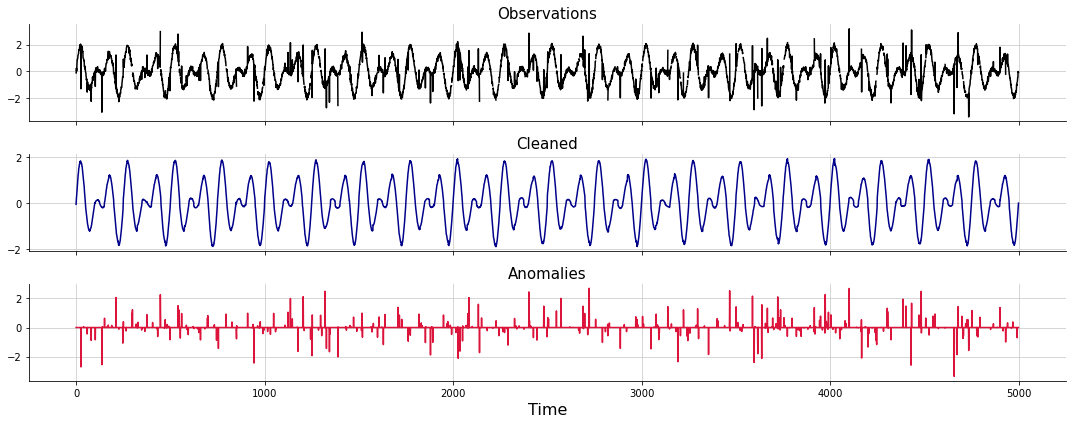

In [32]:
temporal_rpca = TemporalRPCA(n_rows=25, tau=2, lam=0.3, list_periods=[20], list_etas=[0.01], norm="L2")
X, A, errors =  temporal_rpca.fit_transform(signal=samples)
drawing.plot_signal([samples, X, A], style="matplotlib")

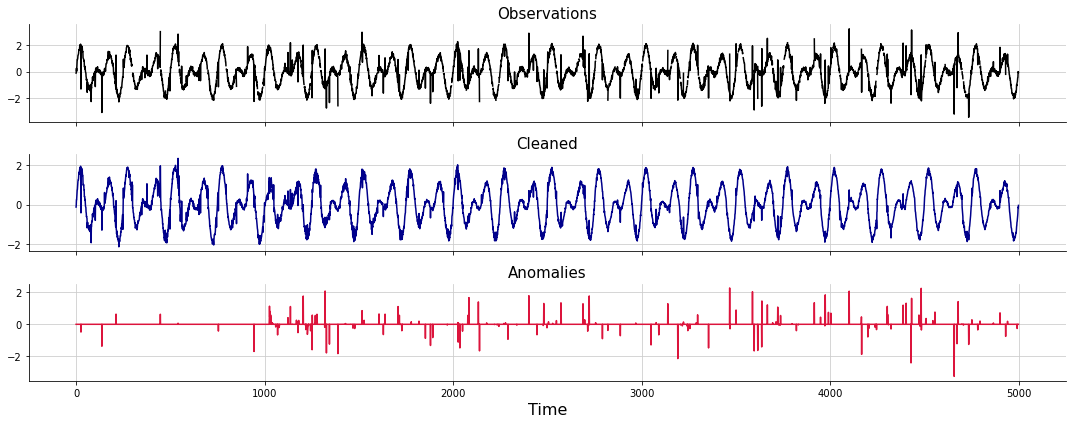

In [35]:
%autoreload 2

online_temp_rpca = OnlineTemporalRPCA(n_rows=25, tau=0.5, lam=0.4, list_periods=[20], list_etas=[0.01], norm="L2",
                       burnin = 0.2, online_list_etas=[0.01])
X, A = online_temp_rpca.fit_transform(signal=samples)
drawing.plot_signal([samples, X, A], style="matplotlib")

**noisy RPCA**

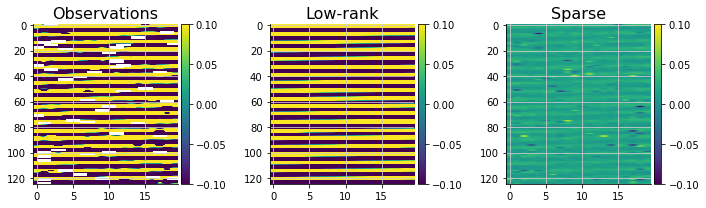

CPU times: user 1min 5s, sys: 18.4 s, total: 1min 23s
Wall time: 11.5 s


In [5]:
%%time

nrpca = NoisyRPCA(signal=samples.tolist(), period=20, tau=3, lam=2.4)
D, X, A = nrpca.compute_noisy_rpca()
drawing.plot_matrices([D, X, A])
s1, s2, s3 = utils.resultRPCA_to_signal(D, X, A, nrpca.ret)
drawing.plot_signal([s1, s2, s3])